# Extrapolating beyond the measurement range
This tutorial demonstrates how the `Inverter` class can be used to estimate and extrapolate the impedance and DRT from truncated data.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy

from bayes_drt.inversion import Inverter
import bayes_drt.file_load as fl
import bayes_drt.plotting as bp

%load_ext autoreload
%autoreload 2

# 1. Load simulated data
For this example, we use data simulated from a circuit consisting of an ohmic resistance, a parallel resistor-inductor (RL) element, and two ZARC elements. The data is truncated such that the impedance responses of the high-frequency RL element and low-frequency ZARC element are not fully captured by the simulated experiment.

In [2]:
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [3]:
# load simulated data
circuit = 'trunc'
err_model = 'uniform'
noise_level = 0.25
df = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_{err_model}_{noise_level}.csv'))

# Extract frequency and impedance arrays
freq, Z = fl.get_fZ(df)

# load exact impedance over full frequency range
df_full = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_noiseless_FullRange.csv'))

# load true drt
g_true = pd.read_csv(os.path.join(datadir,'simulated',f'gamma_{circuit}.csv'))

<IPython.core.display.Javascript object>


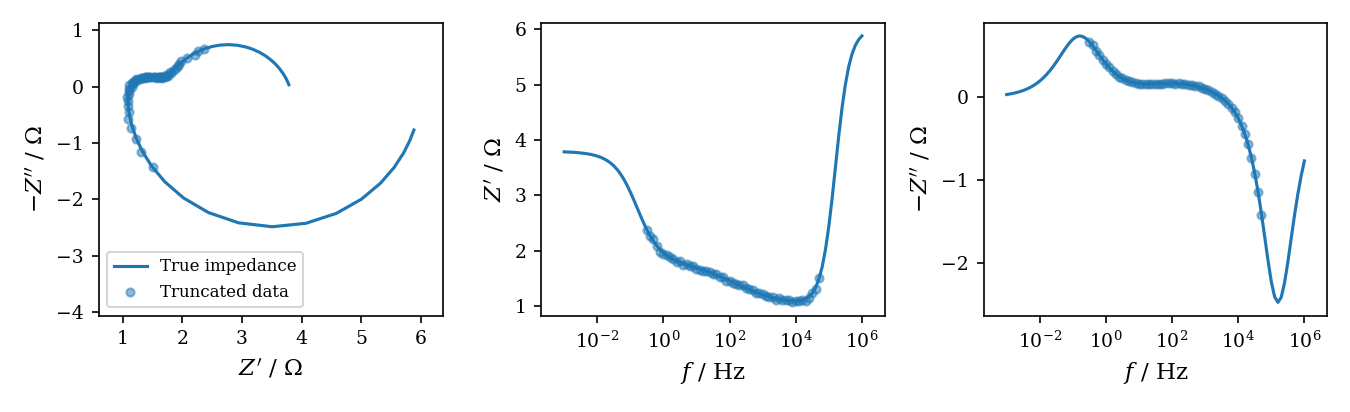

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [5]:
# Plot the truncated, noisy impedance data
axes = bp.plot_eis(df, bode_cols=['Zreal', 'Zimag'], s=15, alpha=0.5, label='Truncated data')

# Plot the full, true impedance
bp.plot_eis(df_full, axes=axes, bode_cols=['Zreal', 'Zimag'], plot_func='plot', label='True impedance')

fig = axes[0].get_figure()
fig.tight_layout()

# 2. Fit with MAP optimization
First, let's fit the data with MAP optimization.

Fit time: 3.73


<IPython.core.display.Javascript object>


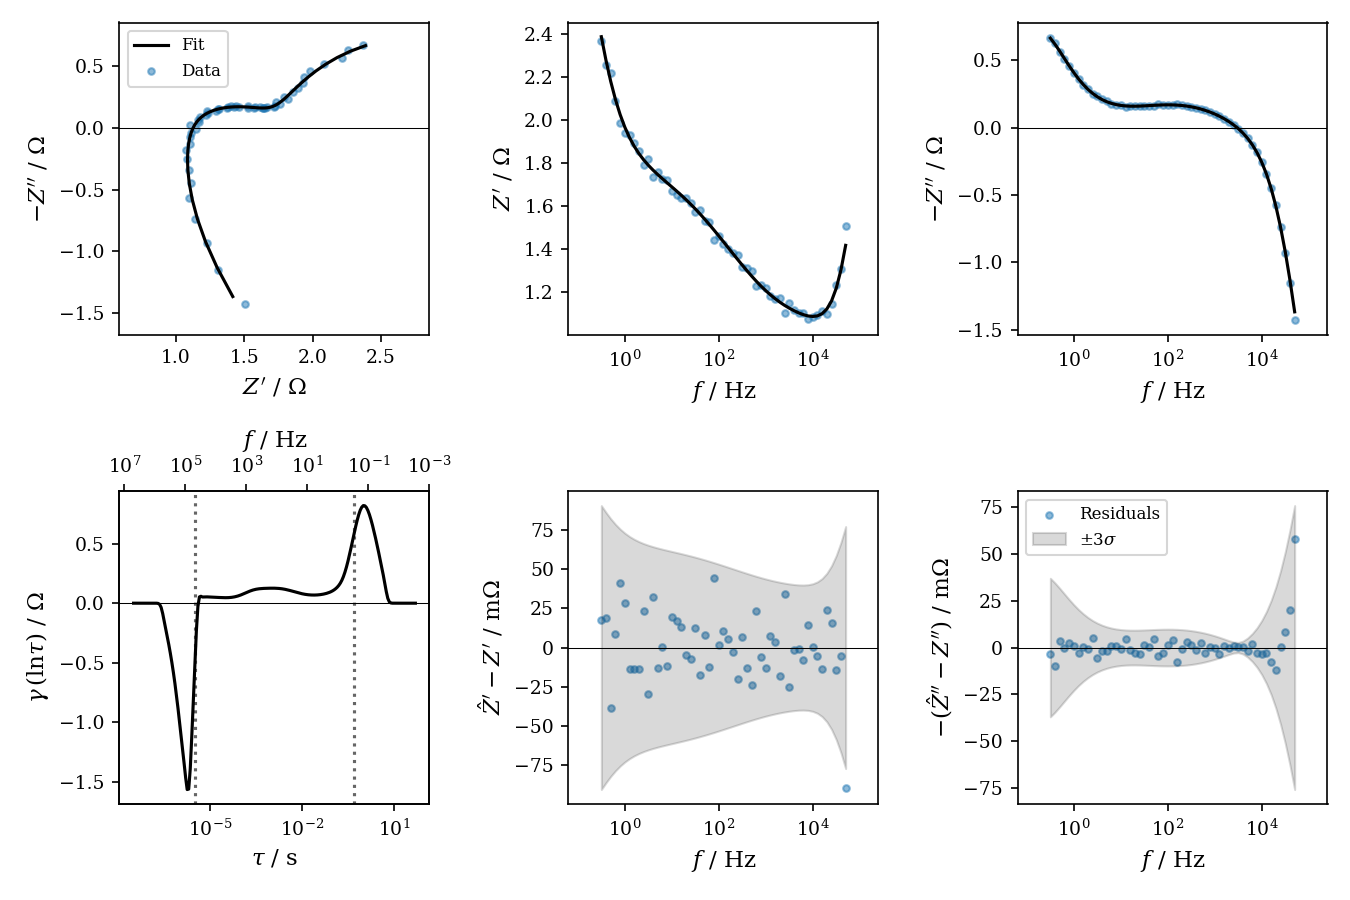

In [25]:
# Use default extended basis
inv_map = Inverter()

# Fit truncated data
start = time.time()
inv_map.fit(freq, Z)
print('Fit time: {:.2f}'.format(time.time() - start))

# Plot results
axes = inv_map.plot_full_results()

The fit of the data is appropriate across the frequency range. 

## 2a. Extrapolate impedance and DRT
We can see how well our fit extrapolates the true impedance by predicting the impedance over the full frequency range of the untruncated simulated data, which extends more than one decade beyond the truncated frequency range in each direction. Supplying the `f_pred` argument to `plot_fit` will produce Nyquist and/or Bode plots of the extrapolated impedance. Similarly, we can view the extrapolation of the DRT beyond the measured frequency range by providing the `tau_plot` argument to `plot_distribution`.

<IPython.core.display.Javascript object>


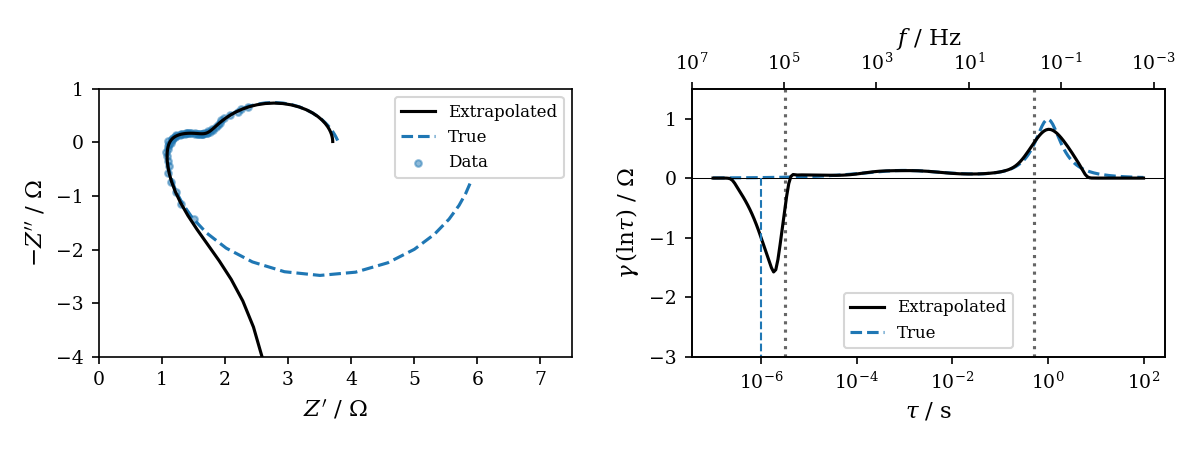

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot impedance fit
# Predict impedance at full set of frequencies
f_pred = df_full['Freq'].values
inv_map.plot_fit(axes=axes[0], f_pred=f_pred, plot_type='nyquist', label='Extrapolated', data_label='Data')
# Plot true impedance
bp.plot_nyquist(df_full, ax=axes[0], plot_func='plot', label='True', zorder=-10, ls='--')

axes[0].set_xlim(0, 7.5)
axes[0].set_ylim(-4, 1)

# Plot estimated DRT over full tau range
inv_map.plot_distribution(ax=axes[1], tau_plot=g_true['tau'], color='k', label='Extrapolated')
# plot true DRT
p = axes[1].plot(g_true['tau'], g_true['gamma'], label='True', zorder=-10, ls='--')
# add vertical line for RL element
axes[1].plot([1e-6, 1e-6], [0, -10], ls='--', lw=1, c=p[0].get_color())

axes[1].set_ylim(-3, 1.5)
axes[1].legend()

fig.tight_layout()

We can see that the extrapolated impedance matches the true impedance very well at low frequencies. At high frequencies, the model places more emphasis on pure inductance than on resistive-inductive (negative DRT) behavior, resulting in a mismatch with the true impedance. However, since only a small portion of the high-frequency negative semicircle is captured in the truncated data and there is a substantial amount of noise, this is an equally reasonable explanation of the data. The model extrapolates both the high-frequency and low-frequency DRT peaks reasonably well.

# 3. Fit with HMC sampling
HMC sampling is handy for extrapolation because it provides credible intervals (CIs) for the extrapolated impedance and DRT. The fitting process is the same as for MAP optimization, but extracting and visualizing the impedance CIs takes a couple extra steps, as shown below.

HMC sampling time: 104.98


<IPython.core.display.Javascript object>


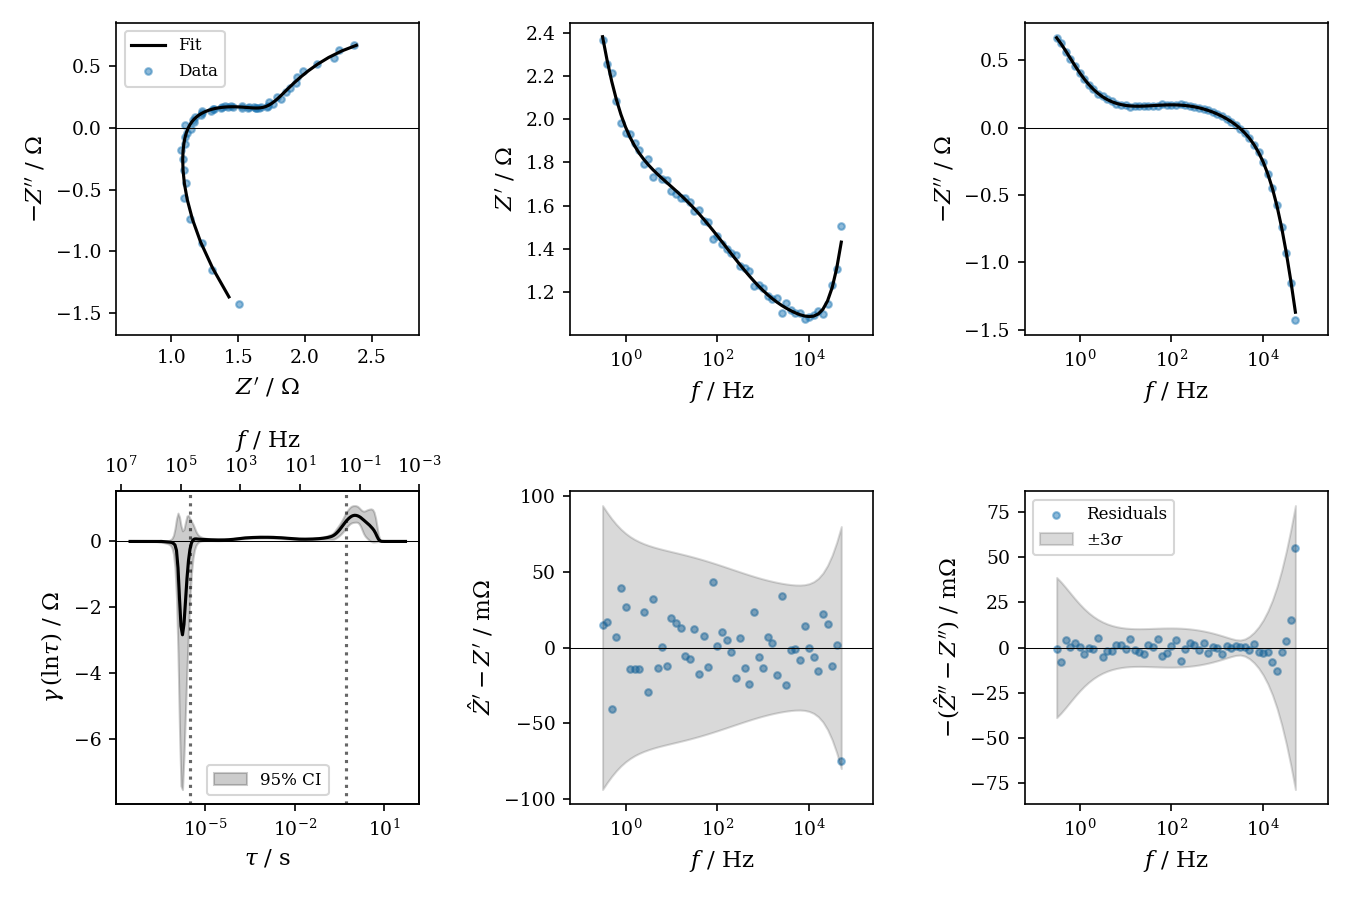

In [27]:
# Use default extended basis
inv_hmc = Inverter()

# Fit truncated data
start = time.time()
inv_hmc.fit(freq, Z, mode='sample')
print('HMC sampling time: {:.2f}'.format(time.time() - start))

# Plot results
axes = inv_hmc.plot_full_results()

As for the MAP fit, the fit of the data is good, and both DRT peaks outside the measured range are reproduced reasonably accurately. Using `plot_full_results` directly provides the CI for the DRT, but not the impedance.

## 3a. Extrapolate impedance and DRT with credible intervals
Next, let's extrapolate the impedance and DRT across the full frequency range.

<IPython.core.display.Javascript object>


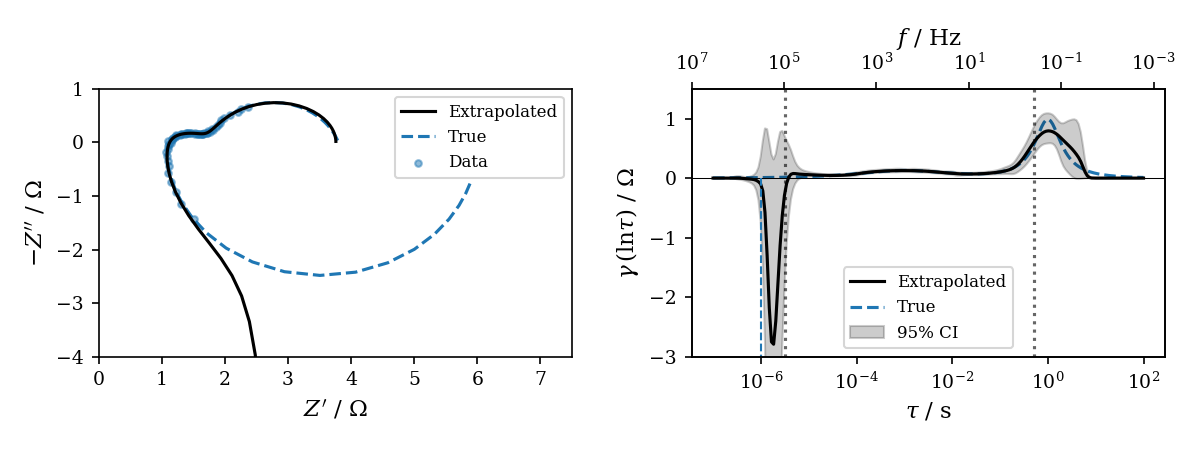

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot impedance fit
# Predict impedance at full set of frequencies
f_pred = df_full['Freq'].values
inv_hmc.plot_fit(axes=axes[0], f_pred=f_pred, plot_type='nyquist', label='Extrapolated', data_label='Data')
# Plot true impedance
bp.plot_nyquist(df_full, ax=axes[0], plot_func='plot', label='True', zorder=-10, ls='--')

axes[0].set_xlim(0, 7.5)
axes[0].set_ylim(-4, 1)

# Plot estimated DRT over full tau range
inv_hmc.plot_distribution(ax=axes[1], tau_plot=g_true['tau'], color='k', label='Extrapolated', ci_label='95% CI')
# plot true DRT
p = axes[1].plot(g_true['tau'], g_true['gamma'], label='True', zorder=-10, ls='--')
# add vertical line for RL element
axes[1].plot([1e-6, 1e-6], [0, -10], ls='--', lw=1, c=p[0].get_color())

axes[1].set_ylim(-3, 1.5)
axes[1].legend()

fig.tight_layout()

The results are very similar to the MAP results.

To produce a CI for the extrapolated impedance, we can use the `predict_Z` method and provide the `percentile` argument. The impedance CI is most easily visualized with Bode plots of $Z^\prime$ and $Z^{\prime\prime}$, as shown below.

<IPython.core.display.Javascript object>


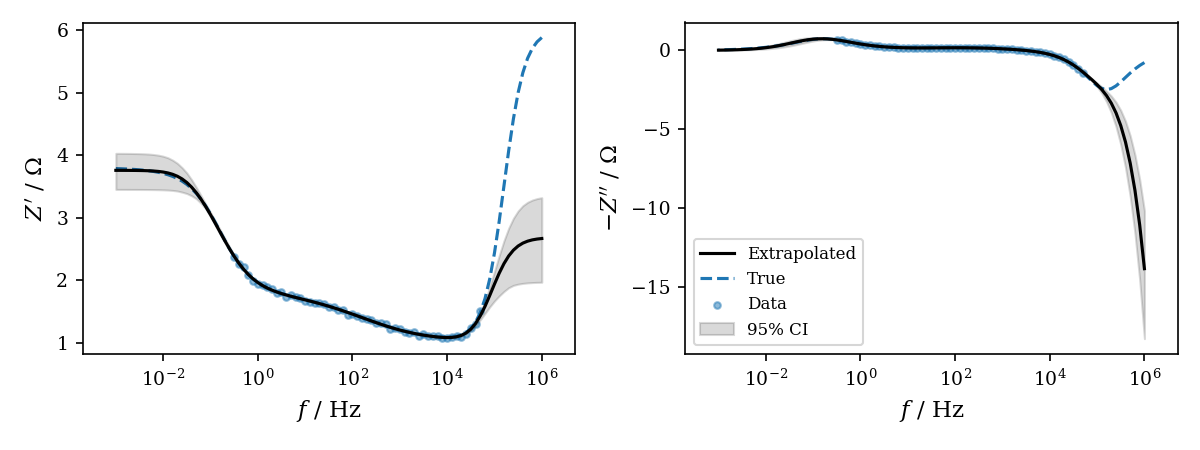

In [40]:
# Extrapolate impedance with CI
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Extract CI bounds
Z_lo = inv_hmc.predict_Z(f_pred, percentile=2.5)
Z_hi = inv_hmc.predict_Z(f_pred, percentile=97.5)

# Plot extrapolated fit
inv_hmc.plot_fit(axes=axes, f_pred=f_pred, plot_type='bode', label='Extrapolated', data_label='Data')

# Plot CI
axes[0].fill_between(f_pred, Z_lo.real, Z_hi.real, color='k', alpha=0.15, label='95% CI')
axes[1].fill_between(f_pred, -Z_lo.imag, -Z_hi.imag, color='k', alpha=0.15, label='95% CI')

# Plot full true impedance
bp.plot_bode(df_full, axes=axes, cols=['Zreal', 'Zimag'], plot_func='plot', ls='--', zorder=-10, label='True')

axes[1].legend()
fig.tight_layout()

The CI matches the true impedance well at low frequencies, but doesn't predict the high-frequency impedance as well due to the ambiguity between pure inductance and resistive-inductive behavior, as mentioned above. The uncertainty in the impedance is very low over the measured frequency range, but quickly grows as we extrapolate outisde of the measured range.

## 3b. Visualizing uncertainty in the Nyquist representation
We can also use the HMC samples to visualize uncertainty in the extrapolated impedance in a Nyquist plot. This is a little trickier, but we can use each HMC sample to predict the impedance, and then view the distribution of those sample impedances.

<IPython.core.display.Javascript object>


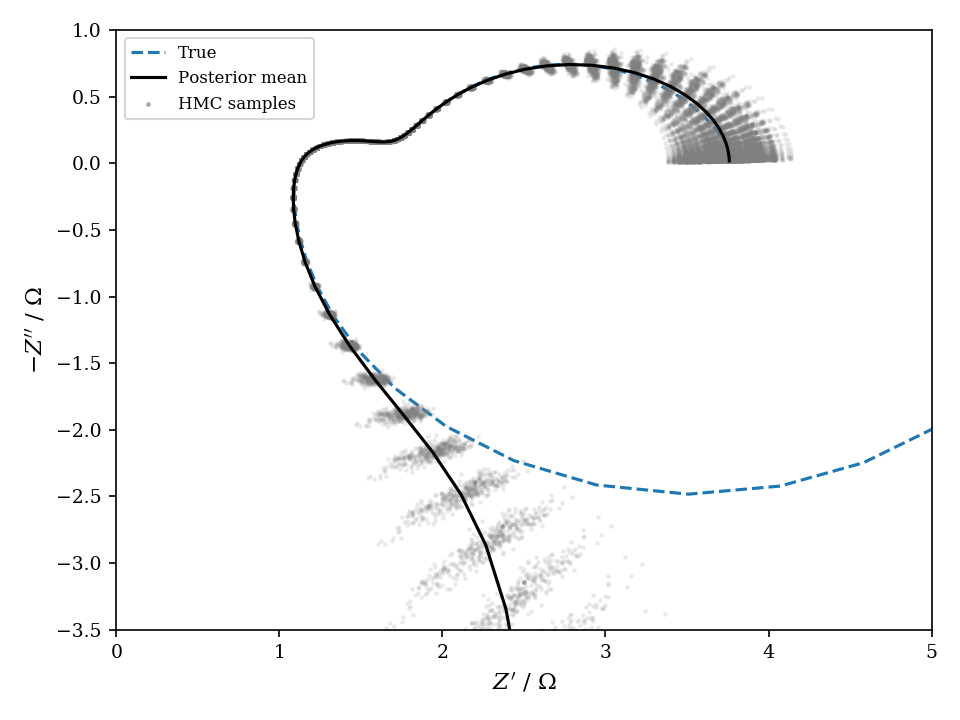

Number of samples: 400


In [45]:
fig, ax = plt.subplots()

# plot the true impedance
bp.plot_nyquist(df_full, plot_func='plot', label='True', ax=ax, ls='--', zorder=-10)

# Plot the posterior mean fit
inv_hmc.plot_fit(axes=ax, plot_type='nyquist', label='Posterior mean', f_pred=f_pred, plot_data=False)

# use the HMC samples to calculate Z samples
Z_pred_matrix = inv_hmc.predict_Z_distribution(f_pred)

# each row of Z_pred_matrix is a sample. Plot each sample
print('Number of samples: {}'.format(Z_pred_matrix.shape[0]))
for i,Zp in enumerate(Z_pred_matrix):
    dfp = fl.construct_eis_df(f_pred, Zp)
    if i==0:
        label='HMC samples'
        # Make first sample darker for legend visibility
        alpha=0.5
    else:
        label=''
        alpha=0.1
    bp.plot_nyquist(dfp, ax=ax,s=2,alpha=alpha,c='gray',label=label)
    
ax.set_xlim(0,5)
ax.set_ylim(-3.5,1)
    
fig.tight_layout()

This again shows how the uncertainty grows as we extrapolated farther outside the measured frequency range.